# Dependencies

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils
from models import tiramisu


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [20]:
CAMVID_PATH = Path('SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [21]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomCrop(224), # crop 224-by-224 section
    joint_transforms.JointRandomHorizontalFlip() # flip with 50% probability
])

train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 367
Val: 101
Test: 233
Classes: 12


c:\Users\olebi\Consulting\Sematic-Segmentation-of-Glioblastoma\pytorch_tiramisu\datasets\camvid.py:55: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  label = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Inputs:  torch.Size([2, 3, 224, 224])
Targets:  torch.Size([2, 224, 224])


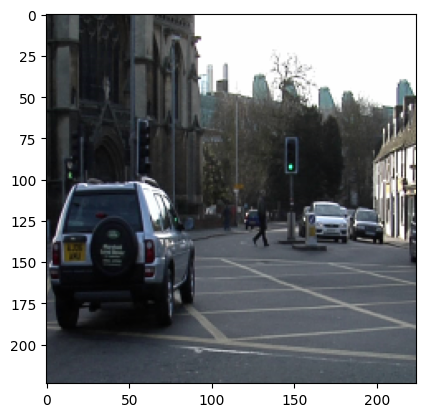

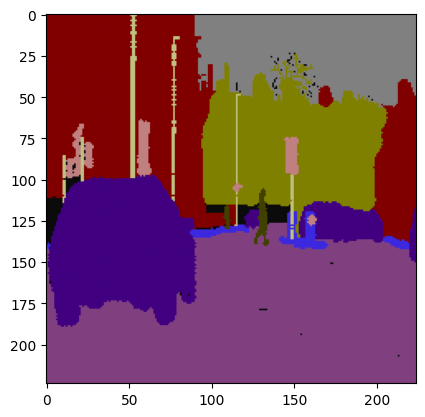

In [22]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])

# Train

In [23]:
LR = 1e-3 # 1e-4 for fine-tuning
LR_DECAY = 0.995 # LR is multiplied by this after every epoch
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2
torch.cuda.manual_seed(0)

Define the model

In [24]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=camvid.class_weight.cuda()).cuda() # compares model prediction to actual data

In [25]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 3.7455, Acc: 0.4155
Train Time 1m 57s


<string>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Val - Loss: 1.6416 | Acc: 0.4830
Total Time 2m 27s

Epoch 2
Train - Loss: 1.9803, Acc: 0.4685
Train Time 1m 57s
Val - Loss: 1.9112 | Acc: 0.5463
Total Time 2m 13s



In [ ]:
train_utils.test(model, test_loader, criterion, epoch=1)  